# Changes:
1. Added Non Local Neural Network blocks to resnet v4

## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

    100% |████████████████████████████████| 519.5MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59afa000 @  0x7fd45d4c21c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 18.1MB/s 
    100% |████████████████████████████████| 2.0MB 3.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 3.3MB 6.1MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
Cloning into 'salt_oil'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/15

In [2]:
cd salt_oil

/content/salt_oil


In [6]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/allen-q/salt_oil
   fa6dcb8..e959b6a  master     -> origin/master
Updating fa6dcb8..e959b6a
Fast-forward
 pytorch_unet/unet/resnet_v5.py | 212 ++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 211 insertions(+), 1 deletion(-)


## Import required libs

In [7]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
from Augmentor.Operations import *
from Augmentor import *
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Unet Modules

In [0]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet_v5 import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [0]:
## Setup data type based on whether GPU is enabled

In [0]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [11]:
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.cuda.FloatTensor'>


## Create Global Variables

In [0]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [0]:
init_global_variables()

In [0]:
def adjust_brightness(img, alpha=None, beta=None):
    if alpha is None:
        # get a random num from 0.75 to 1.25
        alpha = (random.random()/2)+0.75
    if beta is None:
        # get a random num from -30 to 30
        beta = round((random.random()-0.5)*60)
    #print(f'a:{alpha}, b:{beta}')
    img_new = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img_new.reshape(img.shape)

In [0]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, 
                 out_ch=1, transform=None, random_brightness=0):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform
        self.random_brightness = random_brightness

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
            
        X = self.np_img[idx]
        #X = X - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            #X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            X = transformed[:,:,0:1]
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
            
        if self.random_brightness > random.random():            
            X = adjust_brightness(X)
            X = np.clip(X/255, 0., 1.) - self.mean_img
        else:
            X = np.clip(X/255, 0., 1.) - self.mean_img            
        #from boxx import g
        #g()
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')

        d = self.df_depth.iloc[idx,0]

        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).ge(0.5).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [0]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)

    def torch_transform(self):
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:
                    if not isinstance(image, list):
                        image = [image]                        
                    #print(type(operation))
                    #print(np.array(image[0]).shape)                        
                    image = operation.perform_operation(image)[0]

            return image

            
        return _transform
    
    def crop_random_align(self, probability, min_factor, max_factor, mask_diff_pct, resample_filter="BICUBIC"):     
        if not 0 < probability <= 1:
            raise ValueError(Pipeline._probability_error_text)
        elif not (min_factor>0) and (min_factor<=1):
            raise ValueError("min_factor must be between 0 and 1.")
        elif not (max_factor>0) and (min_factor<=1):
            raise ValueError("max_factor must be between 0 and 1.")
        elif resample_filter not in Pipeline._legal_filters:
            raise ValueError("The save_filter argument must be one of %s." % Pipeline._legal_filters)
        else:
            self.add_operation(CropRandomAlign(probability, min_factor, max_factor, mask_diff_pct, resample_filter))
            
    def resize_random(self, probability, min_factor, max_factor, resample_filter="BICUBIC"):
        if not 0 < probability <= 1:
            raise ValueError(Pipeline._probability_error_text)
        elif resample_filter not in Pipeline._legal_filters:
            raise ValueError("The save_filter argument must be one of %s." % Pipeline._legal_filters)
        else:
            self.add_operation(ResizeRandom(probability=probability, min_factor=min_factor,
                                            max_factor=max_factor, resample_filter=resample_filter))

In [0]:
class ResizeRandom(Operation):
    """
    This class is used to resize an image by a random factor between min_factor and max_factor.
    """
    def __init__(self, probability, min_factor, max_factor, resample_filter="BICUBIC"):
        Operation.__init__(self, probability)
        self.min_factor = min_factor
        self.max_factor = max_factor
        self.resample_filter = resample_filter

    def perform_operation(self, images):
        """
        Resize the passed image and returns the resized image. Uses the
        parameters passed to the constructor to resize the passed image.

        :param images: The image to resize.
        :type images: List containing PIL.Image object(s).
        :return: The transformed image(s) as a list of object(s) of type
         PIL.Image.
        """

        def do(image):
            width, height = image.size
            resize_factor = random.randrange(round(self.min_factor*100), round(self.max_factor*100), 1)/100
            width = round(width*resize_factor) 
            height = round(height*resize_factor) 
            print(f'New Width: {width}, New Height: {height}')
            return image.resize((width, height), eval("Image.%s" % self.resample_filter))

        augmented_images = []

        for image in images:
            augmented_images.append(do(image))

        return augmented_images

In [0]:
class CropRandomAlign(Operation):
    """
    This class is used to crop images a random factor between min_factor and max_factor and resize it to its original size.
    """
    def __init__(self, probability, min_factor, max_factor, mask_diff_pct, resample_filter="BICUBIC"):
        Operation.__init__(self, probability)
        self.min_factor = min_factor
        self.max_factor = max_factor
        self.mask_diff_pct = mask_diff_pct
        self.resample_filter = resample_filter

    def perform_operation(self, images):
        """
        Crop the passed :attr:`images` by percentage area, returning the crop as an
        image.

        :param images: The image(s) to crop an area from.
        :type images: List containing PIL.Image object(s).
        :return: The transformed image(s) as a list of object(s) of type
         PIL.Image.
        """

        resize_factor = random.randrange(round(self.min_factor*100), round(self.max_factor*100), 1)/100

        # The images must be of identical size, which is checked by Pipeline.ground_truth().
        w, h = images[0].size

        w_new = int(floor(w * resize_factor))  # TODO: Floor might return 0, so we need to check this.
        h_new = int(floor(h * resize_factor))

        def do(image, w, h):
            img_np = np.array(image)
            mask_in = img_np[:,:,2]
            mask_in_pct = (mask_in>0).sum()/mask_in.size
            img_out_candidate = None
            lowest_diff = 1
            for i in range(20):  
                left_shift = random.randint(0, int((w - w_new)))
                down_shift = random.randint(0, int((h - h_new)))
                img_out = image.crop((left_shift, down_shift, w_new + left_shift, h_new + down_shift))
                mask_out = np.array(img_out)[:,:,2]
                mask_out_pct = (mask_out>0).sum()/mask_out.size
                #print(f'mask_in_pct:{mask_in_pct}, mask_out_pct:{mask_out_pct}')
                if (mask_in_pct==0) or (abs((mask_out_pct/mask_in_pct)-1) <= self.mask_diff_pct):                    
                    img_out_candidate = img_out
                    break
                if (abs((mask_out_pct/mask_in_pct)-1)) <= lowest_diff:
                    lowest_diff = abs((mask_out_pct/mask_in_pct)-1)
                    img_out_candidate = img_out
            if img_out_candidate is None:
                img_out_candidate = image
                print('Failed to crop image to fit requirements. Use orignal image.')
            #print(f'Image Size after crop:{img_out_candidate.size}')
            mask_out = np.array(img_out_candidate)[:,:,2]
            #print(f'image mask pct:{(mask_out>0).sum()/mask_out.size}')
            img_out_final = img_out_candidate.resize((w, h), eval("Image.%s" % self.resample_filter))
            #print(f'Image Size after resize:{img_out_final.size}')            
            
            return img_out_final
            
        augmented_images = []

        for image in images:
            augmented_images.append(do(image, w, h))

        return augmented_images

In [19]:
'''p = Pipeline_Salt()

p.crop_random_align(1, 0.3, 0.5, 0.01)

p.resize_random(probability=1,min_factor=1.1, max_factor=2.5, resample_filter='BILINEAR')

img = np.c_[np.tile(X_train[1507], 2), y_train[1507]]

plt.imshow(img[:,:,2], cmap='gray')

img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)

np.array(img_out).shape

plt.imshow(np.array(img_out)[:,:,2], cmap='gray')'''

"p = Pipeline_Salt()\n\np.crop_random_align(1, 0.3, 0.5, 0.01)\n\np.resize_random(probability=1,min_factor=1.1, max_factor=2.5, resample_filter='BILINEAR')\n\nimg = np.c_[np.tile(X_train[1507], 2), y_train[1507]]\n\nplt.imshow(img[:,:,2], cmap='gray')\n\nimg_in = PIL.Image.fromarray(img)\ntsfm = p.torch_transform()\nimg_out = tsfm(img_in)\n\nnp.array(img_out).shape\n\nplt.imshow(np.array(img_out)[:,:,2], cmap='gray')"

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [20]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Calculate number of mask pixels per image

In [0]:
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])

df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

mask_pix_bins = df_train_mask.mask_pix.sort_values().unique()
# Due to zooming and crop, under-sample all black and all white masks, over-sample images with small mask areas.
mask_pix_bin_weights = ([1.] + np.r_[2:1:102j].tolist() + [0.2])
mask_pix_bin_weights = dict(zip(mask_pix_bins, mask_pix_bin_weights))

train_all_sample_weight = df_train_mask.mask_pix.map(mask_pix_bin_weights)

In [0]:
#np.log10(df_train_mask.mask_pix.div(100).add(10))

### Remove black images

In [0]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [24]:
np_train_all.shape

(4000, 101, 101, 1)

### Remove images with all black masks

In [0]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

### Train Val data split

In [0]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [0]:
X_train_ids, X_val_ids = (
    train_test_split(df_train_mask.index.tolist(), 
                     test_size=0.20,
                     stratify = df_train_mask.mask_pix,
                     random_state=0)
)

In [0]:
with open('./data/df_train_img_iou.pickle', 'rb') as f:
    df_train_img_iou = pickle.load(f)

train_hard_img_id= (
    [misc_data['np_train_all_ids'].index(e) for e in df_train_img_iou.loc[df_train_img_iou.type=='HARD'].id]
)

#X_train_ids = np.setdiff1d(X_train_ids, train_hard_img_id)

In [0]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': np.zeros_like(X_train_mean_img)
}

In [0]:
train_sample_weight = train_all_sample_weight[X_train_ids]

In [0]:
X_train_mean_img = np.zeros_like(X_train_mean_img)

In [32]:
X_train_mean_img

array([0.], dtype=float32)

In [33]:
X_train.shape

(3200, 101, 101, 1)

In [34]:
y_train.shape

(3200, 101, 101, 1)

In [35]:
depth_train.shape

(3200, 1)

In [36]:
'''p = Pipeline_Salt(min_mask_ratio=0.9)
p.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')
img = np.c_[np.tile(X_train[469], 2), y_train[469]]
img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)'''

"p = Pipeline_Salt(min_mask_ratio=0.9)\np.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)\np.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')\nimg = np.c_[np.tile(X_train[469], 2), y_train[469]]\nimg_in = PIL.Image.fromarray(img)\ntsfm = p.torch_transform()\nimg_out = tsfm(img_in)"

In [0]:
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.95, mask_diff_pct=0.2)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

### Create a Train Dataloader

In [0]:
#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([train_data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([train_data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([train_data_params['batch_size']])
assert sample[3].shape == torch.Size([train_data_params['batch_size']])

In [0]:
t = iter(train_dataLoader).__next__()

In [0]:
X_batch, y_batch, d_batch, X_id = t

6059.435294117647, 6075.18408203125


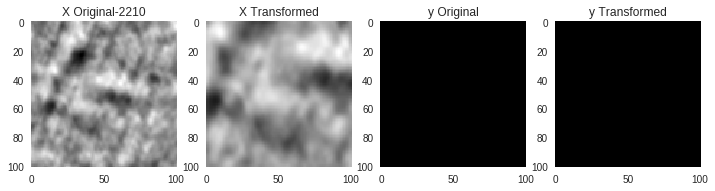

4515.027450980392, 4532.482421875


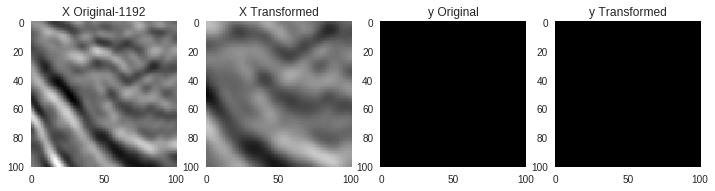

4950.18431372549, 6943.96875


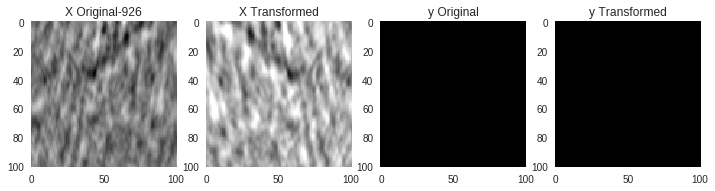

4617.796078431374, 4616.25830078125


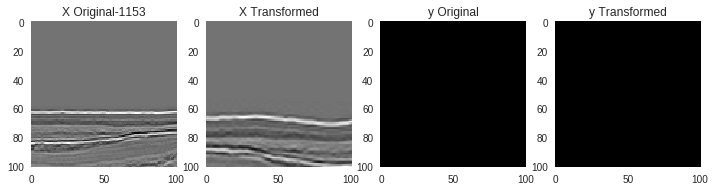

5917.211764705882, 5856.05126953125


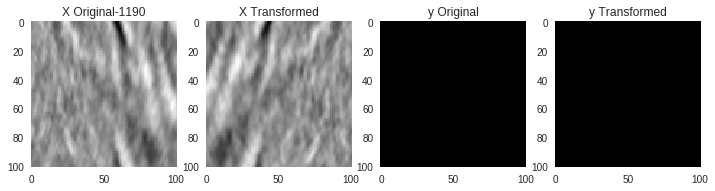

5254.16862745098, 5483.6904296875


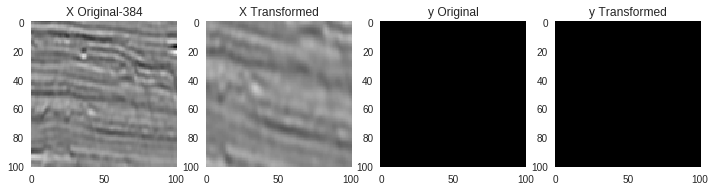

4872.466666666666, 4852.91796875


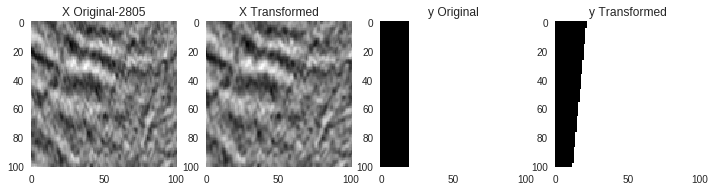

4106.156862745099, 4119.521484375


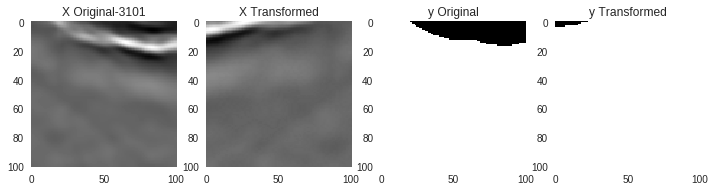

4657.380392156862, 4554.2080078125


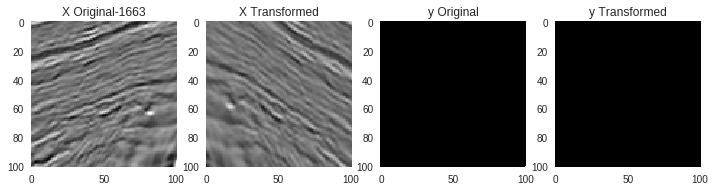

5143.423529411765, 2935.30615234375


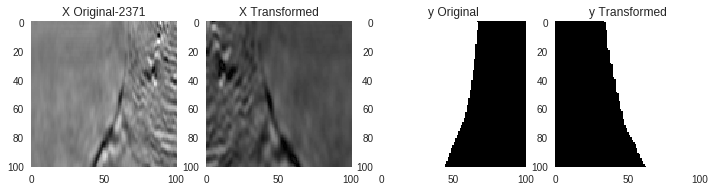

4657.674509803921, 4657.6748046875


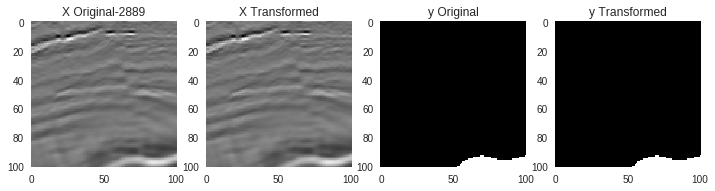

5734.964705882352, 4699.2587890625


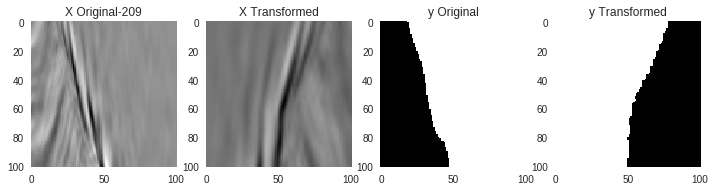

4600.282352941177, 4127.80810546875


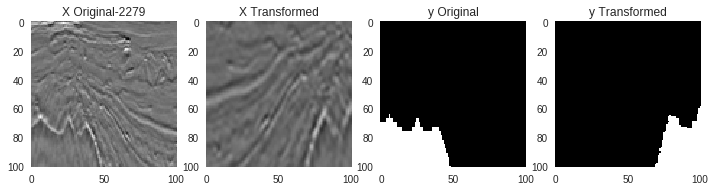

4676.992156862745, 4573.1962890625


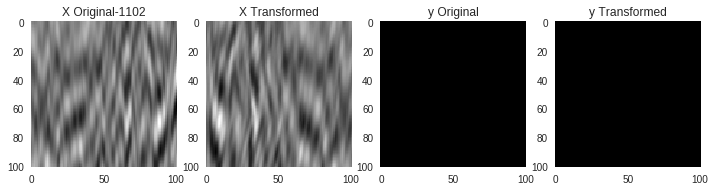

3671.156862745098, 2779.2431640625


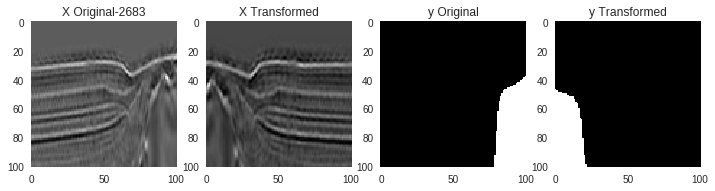

5474.439215686274, 5640.396484375


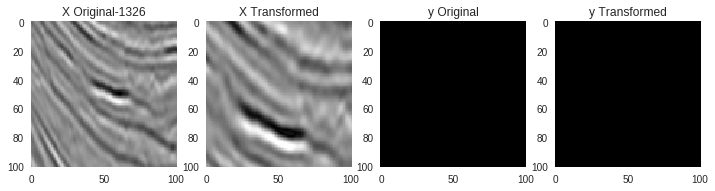

5633.894117647059, 5581.03515625


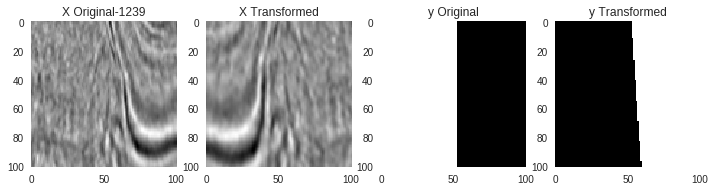

4245.619607843138, 4184.86328125


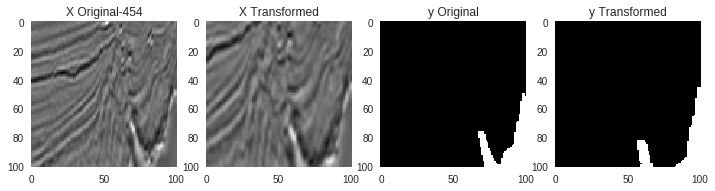

4968.843137254902, 4931.474609375


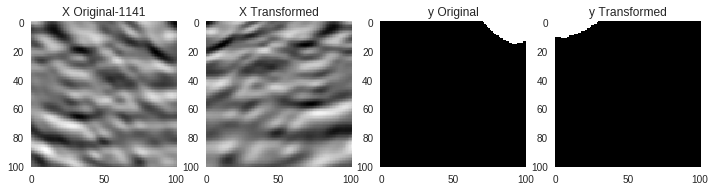

4222.349019607843, 5025.36865234375


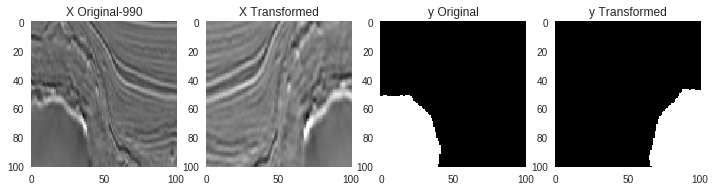

5544.298039215686, 7089.01953125


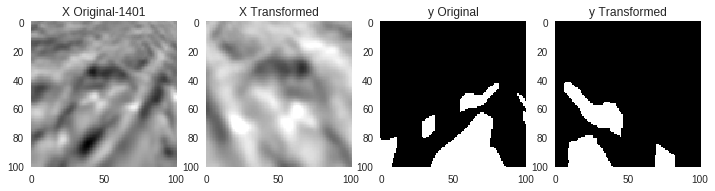

5358.29019607843, 4256.7099609375


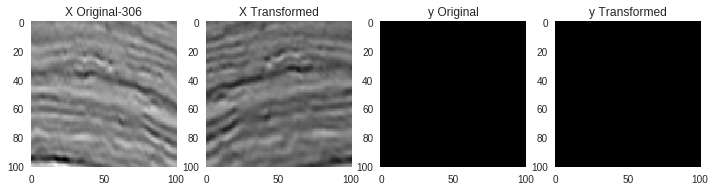

5938.419607843136, 5911.78125


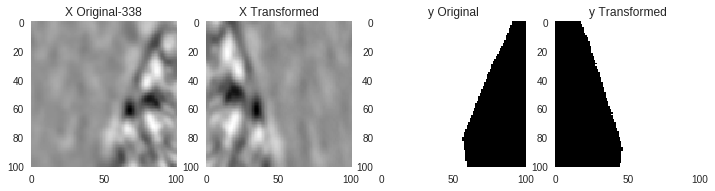

3652.227450980392, 3590.847412109375


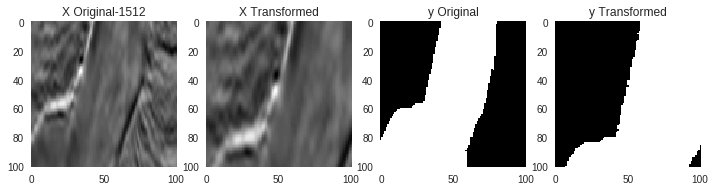

5197.066666666666, 6179.7451171875


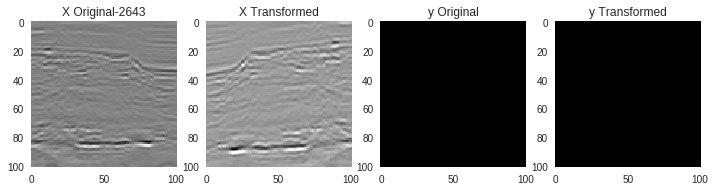

3593.1019607843136, 5130.466796875


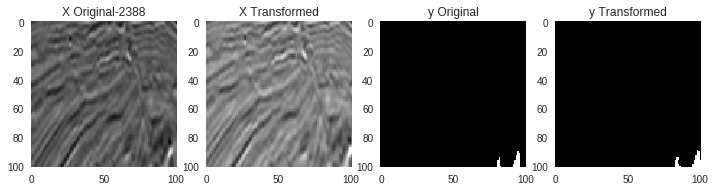

4539.945098039216, 4755.98046875


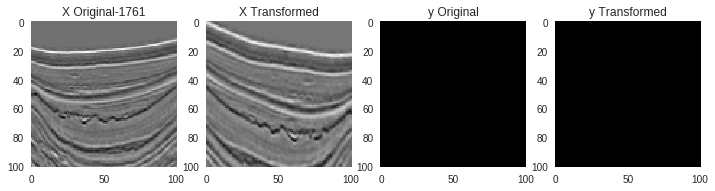

5633.537254901961, 5508.00830078125


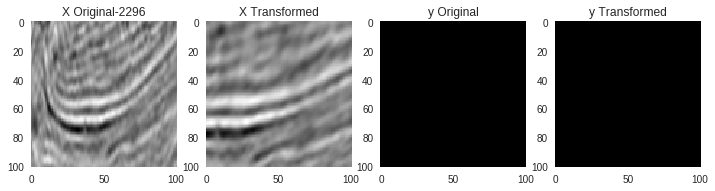

5805.996078431372, 5766.8984375


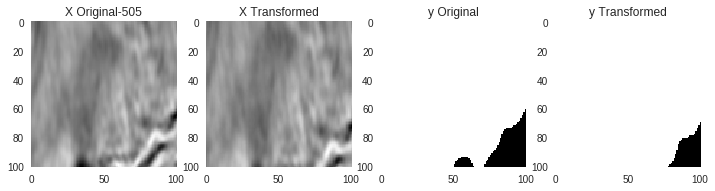

5023.196078431372, 5972.55322265625


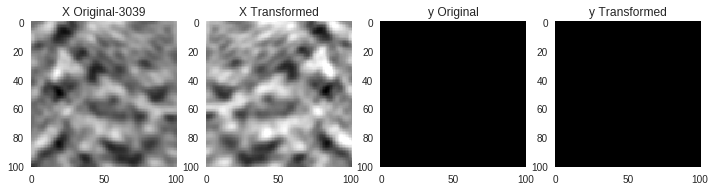

In [41]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>30:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    print(f'{X_orig.sum()}, {X_tsfm.sum()}')
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

### Create a Train Dataloader for sanity check

In [0]:

#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(depth_train['weight'][:8], 2)#weight 
#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values[:8], 2)
train_data_params = {'batch_size': 32, 'shuffle': True,}
val_data_params = {'batch_size': 32, 'shuffle': True,}

In [0]:

train_dataLoader  = (
    DataLoader(SaltDataset(X_train[:32], y_train[:32], depth_train[:32],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **train_data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:32], y_val[:32], depth_val[:32], 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [0]:
t = iter(train_dataLoader).__next__()

In [0]:
X_batch, y_batch, d_batch, X_id = t

In [46]:
X_batch[0].max()

tensor(0.9961, device='cuda:0')

In [0]:
def log_iter_stats(y_pred, y_batch, X_batch, X_id, train_params, other_data, epoch_losses, epoch, iter_count, start):
    #from boxx import g
    #g(), 
    epoch_losses = [round(e.item(),4) for e in torch.stack(epoch_losses).mean(0)]
    iou_batch = calc_mean_iou(y_pred.ge(train_params['mask_cutoff']), y_batch)
    iou_acc = calc_clf_accuracy(y_pred.ge(train_params['mask_cutoff']), y_batch)

    log.info('Losses: {}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
            epoch_losses, iou_batch, iou_acc, iter_count, epoch, timeSince(start))
    )

    X_train = other_data['X_train']
    y_train = other_data['y_train']
    X_train_mean_img = other_data['X_train_mean_img']
    #print(all_losses)
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
    X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    y_tsfm_pred =  y_pred[0].squeeze().gt(train_params['mask_cutoff'])
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

In [0]:
def log_epoch_stats(model, y_pred, y_batch, X_batch, X_id, other_data, pred_vs_true_epoch, train_params, phase, epoch, iter_count, best_iou, all_losses, epoch_losses, best_model):    
    y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
    y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])

    mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(train_params['mask_cutoff']), y_true_epoch.float())
    mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(train_params['mask_cutoff']), y_true_epoch.float())
    mean_loss_epoch = [round(e.item(),4) for e in torch.stack(epoch_losses).mean(0)]

    if phase == 'val':        
        X_val = other_data['X_val']
        y_val = other_data['y_val']
        X_orig = X_val[X_id[0]].squeeze()/255
        y_orig = y_val[X_id[0]].squeeze()
        y_pred2 =  y_pred[0].squeeze().gt(train_params['mask_cutoff'])
        plot_img_mask_pred([X_orig, y_orig, y_pred2],
                           ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if mean_iou_epoch > best_iou:
            best_iou = mean_iou_epoch
            stats = {'best_iou': best_iou,
                   'all_losses': all_losses,
                   'iter_count': iter_count}
            best_model = (epoch, copy.deepcopy(model.state_dict()),
                                              copy.deepcopy(optimizer.state_dict()),
                                              copy.deepcopy(scheduler.state_dict()), stats, train_params['model_save_name'], '.')
            log.info(save_model_state_to_chunks(*best_model))
            log.info('Best Val Mean IOU so far: {}'.format(best_iou))        
        log.info('Val   IOU: {:.4f}, Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
    else:
        log.info('Train IOU: {:.4f}, Acc: {:.4f}, Loss: {} at epoch {}'.format(mean_iou_epoch, mean_acc_epoch, mean_loss_epoch, epoch))
        X_train = other_data['X_train']
        y_train = other_data['y_train']
        X_train_mean_img = other_data['X_train_mean_img']
        X_orig = X_train[X_id[0]].squeeze()/255
        X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
        X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
        y_orig = y_train[X_id[0]].squeeze()
        y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
        y_tsfm_pred =  y_pred[0].squeeze().gt(train_params['mask_cutoff'])
        plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                           ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])
        
    return best_iou, best_model

In [0]:
def save_model_to_git(epoch, train_params, num_epochs, prev_best_iou, best_iou, best_model):    
    if (epoch % train_params['save_model_every']== 0) | (epoch == num_epochs-1):
        if train_params['model_save_name'] is None:
            log.info("Skip pushing model to git as model_save_name is None.")
        elif (best_model is not None) and (best_iou > prev_best_iou):
            log.info(save_model_state_to_chunks(*best_model))
            push_model_to_git(ckp_name=train_params['model_save_name'])
            prev_best_iou = best_iou
        else:
            log.info("Skip pushing model to git as there's no improvement")
            
    return prev_best_iou

In [0]:
def calc_loss(y_pred, y_batch, loss_fns, loss_fn_weights):
     losses = []
     for loss_fn, loss_fn_weight in zip(loss_fns, loss_fn_weights):
         loss = loss_fn_weight * loss_fn(y_pred, y_batch)
         losses.append(loss)  

     return torch.stack(losses + [torch.stack(losses).sum()])

In [0]:
def train_model(model, dataloaders, loss_fns, loss_fn_weights, optimizer, scheduler, train_params, other_data):
    log.info('Start Training...')    
    log.info((dataloaders, loss_fns, loss_fn_weights, optimizer, scheduler, train_params))
    num_epochs = train_params['num_epochs']
    start = time.time()
    if torch.cuda.is_available():
        model.cuda()
    best_model = None
    best_iou = 0.0    
    prev_best_iou = train_params['model_save_iou_threshold']
    all_losses = []
    iter_count = 0

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if (epoch % train_params['save_log_every'] == 0):
            push_log_to_git()
        epoch_losses = []
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()      
            pred_vs_true_epoch = []
            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        losses = calc_loss(y_pred, y_batch.float(), loss_fns, loss_fn_weights)
                        epoch_losses.append(losses)
                        all_losses.append(losses)
                        loss = losses[-1]
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
            best_iou, best_model = log_epoch_stats(model, y_pred, y_batch, X_batch, X_id, other_data, pred_vs_true_epoch, train_params, 
                                                   phase, epoch, iter_count, best_iou, all_losses, epoch_losses, best_model)
            
        prev_best_iou = save_model_to_git(epoch, train_params, num_epochs, prev_best_iou, best_iou, best_model)
        #from boxx import g
        #g()
        epoch_avg_loss = np.mean([e[-1].item() for e in epoch_losses])
        log.info(f'scheduler best: {scheduler.best} num_bad_epochs:{scheduler.num_bad_epochs}')
        log.info(scheduler.step(epoch_avg_loss))


    # load best model weights
    model.load_state_dict(best_model[1])
    log.info('-' * 20)
    log.info(f'Training complete in {(time.time() - start) // 60} mins. Best Val IOU {round(best_iou, 4)}')

    return model

## Train the model using a small data set to see if it can overfit

In [0]:
ll ../salt_net

In [0]:
from pytorch_unet.unet import resnet as resv1

In [57]:
loaded_model = resv1.UResNet()

ResNetnot using pretrained weights.


In [59]:
cd ../salt_net

/content/salt_net


In [0]:
model_file_suffix = "Unet_res34_bce_lovasz_loss_se_new_aug_2018_09_20_12_08_04.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

In [61]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)
saltnet = UResNet(pretrained=loaded_model)

ResNet using pretrained weights.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 40459072.08it/s]


In [63]:
saltnet.conv1_nl

NONLocalBlock2D(
  (g): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (W): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (theta): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (phi): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [0]:


loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.001)
model_save_name = None

# Test Run
#trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
#                other_data=all_data, num_epochs=100, print_every=8, save_model_every=None, save_log_every=None, log=log, loss2_weight=0.0)

In [0]:
train_params = {
    'model_save_name': None,
    'save_model_every': 10000,
    'save_log_every': 100,
    'num_epochs': 10,
    'print_every': 2,
    'log': log,
    'mask_cutoff': 0,
    'model_save_iou_threshold': 0.1
    }

In [0]:
del(loaded_model)

In [68]:
model = train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)

22/09/2018 13:20:44 - SaltNet - INFO - Start Training...
22/09/2018 13:20:44 - SaltNet - INFO - ({'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc68c38fcf8>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc68c38f7f0>}, (BCEWithLogitsLoss(), LovaszHingeLoss()), (1, 0.1), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fc65aeb0320>, {'model_save_name': None, 'save_model_every': 10000, 'save_log_every': 100, 'num_epochs': 10, 'print_every': 2, 'log': <Logger SaltNet (DEBUG)>, 'mask_cutoff': 0, 'model_save_iou_threshold': 0.1})
22/09/2018 13:20:44 - SaltNet - INFO - Epoch 1/10
22/09/2018 13:20:44 - SaltNet - INFO - --------------------


RuntimeError: ignored

## Train the full with full dataset

In [0]:
log.info('Use Unet with Resnet 34 v3 as backbone with Adam and updated data aug class. Added spatial and channel wise SE blocks')

In [0]:
model_config = '''
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.9, mask_diff_pct=0.2)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


#saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold=0.001, min_lr=1e-7, cooldown=1)

model_save_name = f'../salt_net/Unet_res34_v3_bce_lovasz_loss_sc_se{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 200,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.81
    }
    
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)

'''

In [0]:
log.info(model_config)

In [0]:
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.9, mask_diff_pct=0.2)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [0]:
#saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold=0.001, min_lr=1e-7, cooldown=1)

model_save_name = f'../salt_net/Unet_res34_v3_bce_lovasz_loss_sc_se{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

In [0]:
saltnet.decoder1

In [0]:
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 200,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.81
    }


In [0]:
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)

In [0]:
ls

## Fine Tune

In [0]:
log.info('Fine tune Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34 net. Use loss_lovasz_hinge loss only.')

In [0]:
model_config = '''
p = Pipeline_Salt(min_mask_ratio=0.5)
p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune2_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=60, print_every=50, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.0)

'''

In [0]:
log.info(model_config)

In [0]:
cd ../salt_net

In [0]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [0]:
#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune2_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.0)

In [0]:
2879//32

In [0]:
# fine tune 3

In [0]:
log.info('Fine tune Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34 net. Remove hard images. Use loss_lovasz_hinge and bce loss')

In [0]:
model_config = '''
p = Pipeline_Salt(min_mask_ratio=0.5)
p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_se_finetune2_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=50, save_model_every=20, save_log_every=2, log=log, loss1_weight=1.0, loss2_weight=1.0)

'''

In [0]:
log.info(model_config)

In [0]:
cd ../salt_net

In [0]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [0]:
#saltnet = loaded_model
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2.5, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_se_finetune3_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=1.0, loss2_weight=1.0)

In [0]:
# fine tune 4

In [0]:
log.info('Fine tune Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34 net. Remove hard images. Use lovasz loss only with SGD. Less data aug')

In [0]:
model_config = '''
p = Pipeline_Salt(min_mask_ratio=0.1)
#p.skew(probability=1, magnitude=0.5)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.05, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

#saltnet = loaded_model
#loss_fn_bce = nn.BCEWithLogitsLoss()
loss_focal = FocalLoss(0.25, 2.0, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.SGD(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune6_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_focal, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.)

'''

In [0]:
log.info(model_config)

In [0]:
p = Pipeline_Salt(min_mask_ratio=0.1)
#p.skew(probability=1, magnitude=0.5)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.05, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_random(probability=0.5, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')

#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [0]:
cd ../salt_net

In [0]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_finetune_2018_09_15_08_56_34.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

In [0]:
!git status

In [0]:
#saltnet = loaded_model
#loss_fn_bce = nn.BCEWithLogitsLoss()
loss_focal = FocalLoss(0.25, 2.0, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.SGD(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_lovasz_loss_se_finetune6_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_focal, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=44, save_model_every=20, save_log_every=2, log=log, loss1_weight=0.0, loss2_weight=1.)

## Load Trained Model

In [0]:
loaded_model = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)

In [0]:
cd ../salt_net

In [0]:
model_file_suffix = "Unet_bce_loss_lovasz_loss_se_2018_09_14_12_35_12.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [0]:
loaded_model.eval()
assert loaded_model.training == False

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
if torch.cuda.is_available():
    loaded_model.cuda()

In [0]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=16)
y_val_pred_flip = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred_flip.append(loaded_model(X_val_batch))
y_val_pred_flip = torch.cat(y_val_pred_flip)
y_val_pred_flip = torch.flip(y_val_pred_flip,[2])

In [0]:
y_val_pred_ens = torch.where(y_val_pred.abs() > y_val_pred_flip.abs(), y_val_pred, y_val_pred_flip)

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(0), y_val.squeeze())

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred_ens.gt(0.113), y_val.squeeze())

In [0]:
MASK_CUTOFF = 0.113

In [0]:
for i in np.r_[0.05:0.35:20j]:
  print(i)
  y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred_ens.gt(i), y_val.squeeze())

In [0]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=16)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

In [0]:
ZERO_MASK_CUTOFF = 0
MASK_CUTOFF = 0.113

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze())

In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [0]:
range(0, 300, 10)[np.argmax(results)]

In [0]:
results

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

In [0]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze())

In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [0]:
range(0, 3000, 10)[np.argmax(results)]

## Make predictions on test set

In [0]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

### Encode predictions using RLE(Run Length Encoding) method

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [0]:
y_test_pred_adj.shape

In [0]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
df_test_rle[df_test_rle.rle_mask==''].shape

In [0]:
df_test_rle.shape

In [0]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [0]:
ls

In [0]:
from google.colab import files


In [0]:
files.download('submission_2018_09_15_00_18_33.csv') 

## TTA

In [0]:
import numpy as np

### Predict using original image

In [0]:
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

### Predict using flipped images

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=32)
y_test_pred_flip = []

with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_flip.append(loaded_model(X_test_batch))
y_test_pred_flip = torch.cat(y_test_pred_flip)
y_test_pred_flip = torch.flip(y_test_pred_flip,[2])

### Combine non-flip and flip predictions

In [0]:
y_test_pred = torch.where(y_test_pred.abs() > y_test_pred_flip.abs(), y_test_pred, y_test_pred_flip)

### Adjust predictions

In [0]:
print(f'MASK_CUTOFF:{MASK_CUTOFF}, ZERO_MASK_CUTOFF:{ZERO_MASK_CUTOFF}')

In [0]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))


### Show segmentation masks for a few images

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Prepare for submission

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [0]:
y_test_pred_adj.shape

In [0]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
df_test_rle[df_test_rle.rle_mask==''].shape

In [0]:
df_test_rle.shape

In [0]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [0]:
ls

In [0]:
from google.colab import files


In [0]:
files.download('submission_2018_09_20_23_11_23.csv') 